In [ ]:
!pip install -U langchain-community


In [ ]:
import json  # Pour charger des fichiers JSON
from langchain.schema import Document  # Représente un document avec contenu et métadonnées
from langchain.embeddings import HuggingFaceEmbeddings  # Pour créer des embeddings vectoriels
from langchain.vectorstores import FAISS  # Moteur de recherche vectoriel rapide
from langchain.chains import RetrievalQA  # Chaîne pour question-réponse avec récupération documentaire
from langchain.prompts import PromptTemplate  # Pour créer des modèles de prompt personnalisés
from langchain.llms import Ollama  # Interface LLM Ollama

def prepare_documents(data):
    """
    Transforme les données brutes en une liste d’objets Document,
    avec des métadonnées utiles pour la recherche et le filtrage.
    """

    documents = []  # Liste qui contiendra tous les documents préparés

    # Parcours chaque post du dataset
    for post in data["posts"]:
        problem = post["problem"]  # Récupère la description du problème

        # Détection basique d'erreur dans la description via mots-clés
        is_error = any(kw in problem.lower() for kw in
                      ['error', 'fail', 'issue', 'not working', 'exception'])

        # Parcours toutes les solutions proposées pour ce problème
        for sol in post["solutions"]:
            # Crée un Document LangChain combinant problème et solution
            doc = Document(
                page_content=f"PROBLEM: {problem}\nSOLUTION: {sol}",  # Contenu textuel
                metadata={
                    "is_error": is_error,  # Booléen indiquant si c’est un problème d’erreur
                    "has_code": any(x in sol for x in ['=', '(', '{', 'http']),  # Probablement contient du code ou des liens
                    "is_screenshot": "[Technical Screenshot:" in sol,  # Indique la présence d’une capture d’écran technique
                    "source": "dataset"  # Indique que le document vient du dataset
                }
            )
            documents.append(doc)  # Ajoute le document à la liste

    return documents  # Retourne la liste complète de documents prêts à l’usage


In [ ]:
from langchain.vectorstores.base import VectorStoreRetriever  # Classe de base pour créer un retriever personnalisé
from typing import List  # Pour annoter les types des retours de fonctions
from langchain.schema import Document  # Structure d’un document LangChain

# Définition d’un retriever personnalisé, héritant de VectorStoreRetriever
class CustomRetriever(VectorStoreRetriever):
    # Surcharge de la méthode pour récupérer les documents les plus pertinents selon la requête
    def get_relevant_documents(self, query: str) -> List[Document]:
        k = 3  # Nombre final de documents à retourner

        # Détection si la requête concerne un problème d’erreur selon des mots-clés
        is_error_query = any(kw in query.lower() for kw in
                             ['error', 'fail', 'bug', 'not working'])

        # Recherche des 2*k documents les plus similaires à la requête dans le vectorstore
        docs = self.vectorstore.similarity_search(query, k=k*2)

        # Si la requête est liée à une erreur, on trie pour prioriser les documents avec captures d’écran et code
        if is_error_query:
            docs.sort(key=lambda x: (
                x.metadata.get("is_screenshot", False),  # True = priorité plus haute
                x.metadata.get("has_code", False)        # True = priorité plus haute
            ), reverse=True)  # Tri descendant

        # Retourne seulement les k premiers documents après tri ou sélection
        return docs[:k]

# Fonction utilitaire pour créer un retriever à partir d’une liste de documents
def create_retriever(documents):
    # Crée un modèle d’embeddings MiniLM pour vectoriser les documents
    embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

    # Crée un index FAISS à partir des documents vectorisés
    vectorstore = FAISS.from_documents(documents, embedding)

    # Retourne une instance du retriever personnalisé avec le vectorstore attaché
    return CustomRetriever(vectorstore=vectorstore)


/tmp/ipython-input-19-1096795745.py:5: DeprecationWarning: Retrievers must implement abstract `_get_relevant_documents` method instead of `get_relevant_documents`
  class CustomRetriever(VectorStoreRetriever):


In [ ]:
from langchain.chains import RetrievalQA  # Chaîne qui combine récupération documentaire et LLM
from langchain.prompts import PromptTemplate  # Pour créer des templates de prompt personnalisés

def create_qa_chain(retriever, llm):
    """
    Crée une chaîne RetrievalQA qui utilise un retriever et un LLM,
    avec un prompt structuré pour fournir des solutions précises et concises.
    """

    # Template de prompt qui guide le modèle pour répondre selon un format strict
    template = """As an OutSystems expert, provide CONCISE solutions:

{context}

Question: {question}

Answer in this EXACT format:
1. Issue Type: [Technical/General]
2. Root Cause: [1-2 sentences]
3. Immediate Fix: [Specific steps]
4. Prevention: [Best practices]
5. Resources: [Screenshots/code if available]"""

    # Création du prompt avec les variables d'entrée qui seront remplacées lors de l'exécution
    prompt = PromptTemplate(
        template=template,
        input_variables=["context", "question"]  # 'context' = documents récupérés, 'question' = la requête utilisateur
    )

    # Création de la chaîne RetrievalQA
    return RetrievalQA.from_chain_type(
        llm=llm,                # Modèle de langage utilisé pour générer la réponse
        chain_type="stuff",     # Stratégie de concaténation : tous les docs sont "stuffés" dans le prompt
        retriever=retriever,    # Moteur qui va chercher les documents pertinents
        return_source_documents=True,  # Retourne aussi les documents sources ayant servi à générer la réponse
        chain_type_kwargs={
            "prompt": prompt,                       # Utilise le prompt personnalisé défini ci-dessus
            "document_separator": "\n\n---\n\n"   # Séparateur entre documents dans le contexte envoyé au LLM
        }
    )


In [ ]:
def generate_solutions(user_query, qa_chain, llm):
    """
    Combine les connaissances issues du dataset avec celles du LLM.
    Tente d'abord de répondre à partir des documents, sinon utilise le LLM seul.
    """

    # Étape 1 : Interroger la chaîne QA pour récupérer une réponse basée sur le dataset
    result = qa_chain.invoke({"query": user_query})

    # Récupérer les documents source qui ont servi à générer la réponse
    sources = result.get("source_documents", [])

    # Étape 2 : Évaluer la qualité des documents récupérés
    # On considère une bonne correspondance si au moins un document contient du code ou une capture d’écran
    has_good_match = any(
        doc.metadata["has_code"] or
        doc.metadata["is_screenshot"]
        for doc in sources
    )

    if has_good_match:
        # Étape 3 : Si un bon match existe, formater une réponse issue du dataset
        answer = "🔍 [Dataset-Based Solution]\n" + result["result"]

        # Extraire un aperçu (200 caractères) des solutions associées pour affichage
        sources_text = "\n".join(
            f"- {doc.page_content.split('SOLUTION:')[1][:200]}..."
            for doc in sources
        )

        # Retourner la réponse complète avec un label et les extraits des solutions trouvées
        return {
            "answer": f"{answer}\n\n📚 Matching Solutions:\n{sources_text}",
            "source": "dataset"
        }

    else:
        # Étape 4 : Sinon, utiliser le LLM seul pour générer une réponse générale structurée
        llm_response = llm.invoke(
            f"As an OutSystems expert, answer concisely: {user_query}\n"
            "Format:\n"
            "1. Likely Cause\n"
            "2. Recommended Fix\n"
            "3. Prevention Tips\n"
            "[Label this as 'General Knowledge']"
        )

        # Retourner la réponse générée par le LLM avec un label indiquant la source
        return {
            "answer": f"💡 [General Knowledge]\n{llm_response}",
            "source": "llm"
        }


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install faiss-cpu


In [ ]:
from langchain.llms import Ollama  # Add this import at the top of your file
import json
import hashlib


In [ ]:
# Installe Ollama (outil de modèles LLM locaux)
!curl -fsSL https://ollama.com/install.sh | sh

# Lance le serveur Ollama en arrière-plan
!nohup ollama serve &

# Télécharge le modèle LLM 'phi3'
!ollama pull phi3


>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
nohup: appending output to 'nohup.out'



In [ ]:
import time  # Pour gérer les délais entre les tentatives de connexion
from langchain.llms import Ollama  # Import du LLM Ollama via LangChain

def get_llm():
    max_retries = 3  # Nombre maximum de tentatives en cas d'échec
    retry_delay = 5  # Temps d'attente (en secondes) entre chaque tentative

    for attempt in range(max_retries):
        try:
            # Initialisation du modèle phi3 avec température basse (réponses plus précises)
            llm = Ollama(
                model="phi3",
                temperature=0.3,
                base_url='http://localhost:11434'
            )
            # Test de connexion en envoyant une requête simple
            llm("Test")
            return llm  # Retourne le LLM s’il fonctionne
        except Exception as e:
            # Affiche un message d’erreur et attend avant de réessayer
            print(f"Attempt {attempt + 1} failed, retrying...")
            time.sleep(retry_delay)

    # Lève une erreur si toutes les tentatives échouent
    raise ConnectionError("Failed to connect to Ollama after multiple attempts")

llm = get_llm()  # Appelle la fonction pour récupérer une instance fonctionnelle du LLM


In [ ]:
def initialize_qa_system():
    try:
        print("🔄 Initializing OutSystems Advisor...")

        # Chargement du fichier JSON contenant les données prétraitées
        with open('/content/drive/MyDrive/pfe/preprocessed_data (1).json') as f:
            data = json.load(f)

        # Transformation des données en objets Document avec métadonnées
        documents = prepare_documents(data)

        # Création du système de recherche basé sur les embeddings et FAISS
        retriever = create_retriever(documents)

        # Chargement du modèle LLM local "phi3" via Ollama
        llm = Ollama(model="phi3")

        # Construction de la chaîne de question/réponse avec contexte
        qa_chain = create_qa_chain(retriever, llm)

        print("✅ QA System Ready.\n")
        return qa_chain, llm  # Retourne les composants nécessaires pour interroger le système

    except Exception as e:
        # Gestion des erreurs lors de l'initialisation
        print(f"\033[1;31m❌ Initialization Failed: {str(e)}\033[0m")
        return None, None  # En cas d’échec, retourne des objets vides


***Enter an input message to generate its suitable solution***

In [ ]:
import json  # Importation du module JSON pour charger les données

def test_interface():
    print("🔄 Initializing OutSystems Advisor...")

    try:
        # Chargement des données prétraitées depuis un fichier JSON
        with open('/content/drive/MyDrive/pfe/preprocessed_data.json') as f:
            data = json.load(f)

        # Transformation des données en objets Document
        documents = prepare_documents(data)

        # Création du système de recherche basé sur FAISS
        retriever = create_retriever(documents)

        # Initialisation du modèle LLM local 'phi3' via Ollama
        llm = Ollama(model="phi3")

        # Création de la chaîne de question-réponse à partir du retriever et du modèle
        qa_chain = create_qa_chain(retriever, llm)

        print("\n✅ System Ready | Type 'exit' to quit\n")

        # Boucle interactive pour interroger le système
        while True:
            user_input = input("💬 Describe your issue: ").strip()
            if user_input.lower() == 'exit':
                break  # Quitte la boucle si l'utilisateur tape "exit"

            # Génère une réponse à partir du système QA
            response = generate_solutions(user_input, qa_chain, llm)

            # Affiche la réponse avec une couleur différente selon sa source
            if response["source"] == "dataset":
                print(f"\033[1;32m{response['answer']}\033[0m")  # Vert = réponse issue du dataset
            elif response["source"] == "llm":
                print(f"\033[1;36m{response['answer']}\033[0m")  # Bleu = réponse générée par le modèle LLM
            else:
                print(f"\033[1;31m{response['answer']}\033[0m")  # Rouge = autre cas ou erreur

            print("\n" + "="*80 + "\n")  # Séparateur visuel entre les réponses

    except Exception as e:
        # Affiche une erreur si le système échoue à l'initialisation
        print(f"\033[1;31m❌ Initialization Failed: {str(e)}\033[0m")

# Lancement de l'interface
test_interface()


***BENCHMARKING : Evaluating phi-3 for a bunch of problems***

In [ ]:
import pandas as pd  # Importation de la bibliothèque pandas pour manipuler les tableaux de données

def benchmark_quality(qa_chain, llm, test_cases):
    results = []  # Liste pour stocker les résultats de chaque test

    for case in test_cases:
        query = case["query"]  # La question du test
        expected_keywords = case["expected_keywords"]  # Mots-clés attendus dans la réponse

        # Génération de la réponse en utilisant le système QA
        response = generate_solutions(query, qa_chain, llm)
        answer = response["answer"].lower()  # Mise en minuscules pour comparer facilement

        # Vérification des mots-clés attendus présents dans la réponse
        matched_keywords = [kw for kw in expected_keywords if kw.lower() in answer]
        score = len(matched_keywords) / len(expected_keywords) * 100  # Score de correspondance en %

        # Enregistrement des résultats pour ce test
        results.append({
            "query": query,
            "matched": len(matched_keywords),  # Nombre de mots-clés retrouvés
            "total": len(expected_keywords),  # Nombre total de mots-clés attendus
            "match_score": score,  # Score de correspondance
            "missing": [kw for kw in expected_keywords if kw.lower() not in answer],  # Mots-clés manquants
            "source": response["source"],  # Source de la réponse (dataset ou llm)
            "answer": response["answer"]  # Réponse complète générée
        })

    # Création d'un DataFrame pandas avec tous les résultats
    df = pd.DataFrame(results)

    # Sauvegarde des résultats dans un fichier CSV
    df.to_csv("/content/drive/MyDrive/pfe/benchmark_results.csv", index=False)

    # Affichage du résumé global des performances
    print(f"📊 Final Benchmark Summary:\n🎯 Avg Match Score: {df['match_score'].mean():.2f}% over {len(df)} queries")

    return df  # Retourne le DataFrame contenant tous les résultats


In [ ]:
!pip install seaborn


In [ ]:
import seaborn as sns  # Bibliothèque pour la visualisation statistique (basée sur matplotlib)
import matplotlib.pyplot as plt  # Bibliothèque principale pour les graphiques

def visualize_benchmark(df):
    # 🔹 Barplot : Score de correspondance par requête
    plt.figure(figsize=(12, 6))  # Définir la taille de la figure
    sns.barplot(x=df.index, y="match_score", data=df)  # Barres pour chaque requête avec son score
    plt.title("Match Score per Query")  # Titre du graphique
    plt.xlabel("Query Index")  # Étiquette axe X
    plt.ylabel("Match Score (%)")  # Étiquette axe Y
    plt.ylim(0, 100)  # Limite de l’axe Y de 0 à 100 %
    
    # 🔸 Ajouter une ligne horizontale rouge représentant la moyenne
    plt.axhline(df["match_score"].mean(), color='red', linestyle='--', label='Average')
    plt.legend()  # Afficher la légende
    plt.tight_layout()  # Ajuster automatiquement les marges
    plt.show()  # Afficher le graphique

    # 🔹 Camembert : Répartition des sources utilisées (dataset vs LLM)
    plt.figure(figsize=(6, 6))  # Taille du camembert
    df["source"].value_counts().plot.pie(
        autopct="%1.1f%%",  # Format des pourcentages
        colors=["lightgreen", "skyblue"]  # Couleurs personnalisées
    )
    plt.title("Answer Source Distribution")  # Titre du graphique
    plt.ylabel("")  # Supprimer le label de l'axe Y
    plt.show()  # Afficher le camembert


🔄 Initializing OutSystems Advisor...


/tmp/ipython-input-19-1096795745.py:23: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warning

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ QA System Ready.

📊 Final Benchmark Summary:
🎯 Avg Match Score: 86.67% over 10 queries


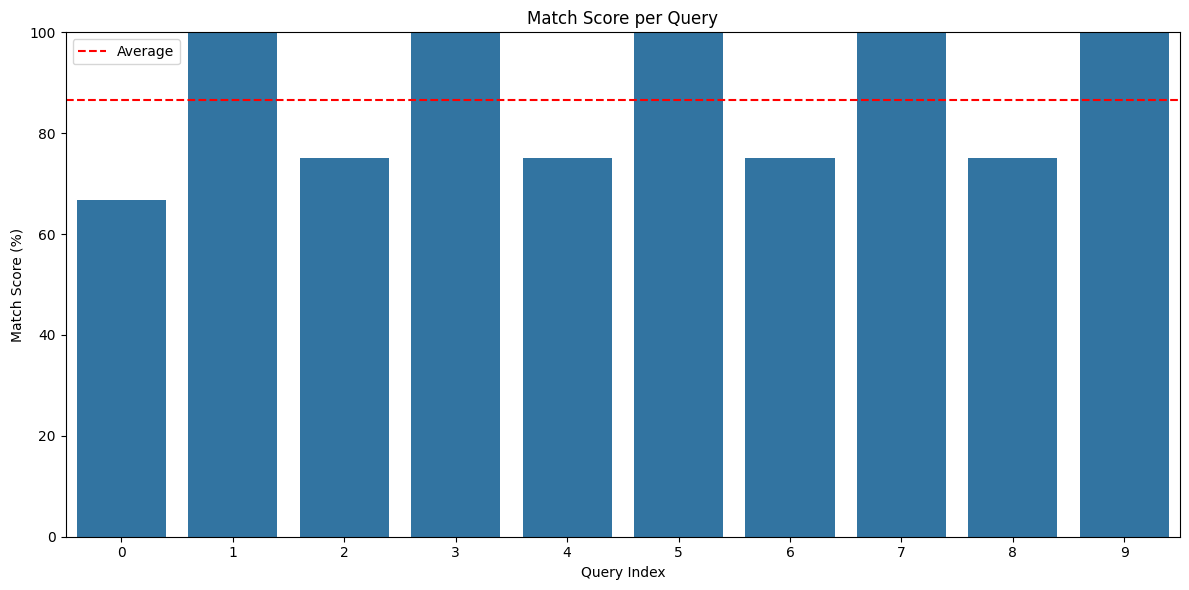

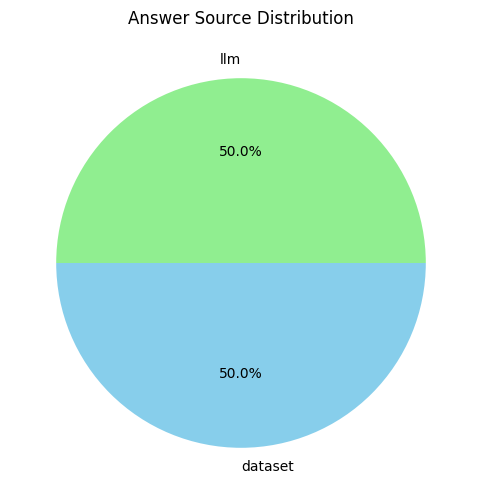

In [ ]:
# 📥 Charger les cas de test depuis un fichier JSON
with open('/content/drive/MyDrive/pfe/benchmark_cases.json') as f:
    test_cases = json.load(f)

# ⚙️ Initialiser le système QA (modèle + base de connaissances)
qa_chain, llm = initialize_qa_system()

# 🧪 Évaluer la qualité des réponses avec les cas de test
df = benchmark_quality(qa_chain, llm, test_cases)

# 📊 Visualiser les résultats de l'évaluation (scores et sources)
visualize_benchmark(df)
